In [142]:
import math
#import
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data.dataloader import default_collate
import matplotlib.pyplot as plt
import torchnet as tnt
import random
import copy
import numpy as np
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import multi_dot
from scipy.sparse.linalg import cg
import faiss
from IPython.display import display
%config InlineBackend.figure_format = 'retina'


Labels = "/data02/Atin/mean-teacher/pytorch/data-local/labels/cifar10/4000_balanced_labels/00.txt"
# Labels = "/data02/Atin/mean-teacher/pytorch/data-local/labels/cifar10/1000_balanced_labels/00.txt"


Rotnet_Conv_Model_Loc = "/home/atin/SSL-real_data/rotnet_conv_model_con_latest.pt"
# Rotnet_Conv_Model_Loc = "/home/atin/SSL-real_data/rotnet_conv_model_con_latest_500.pt"
# Rotnet_Conv_Model_Loc = "/home/atin/SSL-real_data/rotnet_conv_model_con.pt"




Lr = .1
Nb_epoch = 30
Epochs = Nb_epoch
Lr_rampdown_epochs = 1.5*Nb_epoch

In [143]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super(BasicBlock, self).__init__()
        padding = int((kernel_size - 1) / 2)
        self.layers = nn.Sequential()
        self.layers.add_module('Conv', nn.Conv2d(in_planes, out_planes,
                                                 kernel_size=kernel_size, stride=1, padding=padding, bias=False))
        self.layers.add_module('BatchNorm', nn.BatchNorm2d(out_planes))
        self.layers.add_module('ReLU', nn.ReLU(inplace=True))

    def forward(self, x):
        return self.layers(x)
        feat = F.avg_pool2d(feat, feat.size(3)).view(-1, self.nChannels)


class GlobalAveragePooling(nn.Module):
    def __init__(self):
        super(GlobalAveragePooling, self).__init__()

    def forward(self, feat):
        num_channels = feat.size(1)
        return F.avg_pool2d(feat, (feat.size(2), feat.size(3))).view(-1, num_channels)


class NetworkInNetwork(nn.Module):
    def __init__(self, opt):
        super(NetworkInNetwork, self).__init__()

        num_classes = opt['num_classes']
        num_inchannels = opt['num_inchannels'] if ('num_inchannels' in opt) else 3
        num_stages = opt['num_stages'] if ('num_stages' in opt) else 3
        use_avg_on_conv3 = opt['use_avg_on_conv3'] if ('use_avg_on_conv3' in opt) else True

        assert (num_stages >= 3)
        nChannels = 192
        nChannels2 = 160
        nChannels3 = 96

        blocks = [nn.Sequential() for i in range(num_stages)]
        # 1st block
        blocks[0].add_module('Block1_ConvB1', BasicBlock(num_inchannels, nChannels, 5))
        blocks[0].add_module('Block1_ConvB2', BasicBlock(nChannels, nChannels2, 1))
        blocks[0].add_module('Block1_ConvB3', BasicBlock(nChannels2, nChannels3, 1))
        blocks[0].add_module('Block1_MaxPool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        # 2nd block
        blocks[1].add_module('Block2_ConvB1', BasicBlock(nChannels3, nChannels, 5))
        blocks[1].add_module('Block2_ConvB2', BasicBlock(nChannels, nChannels, 1))
        blocks[1].add_module('Block2_ConvB3', BasicBlock(nChannels, nChannels, 1))
        blocks[1].add_module('Block2_AvgPool', nn.AvgPool2d(kernel_size=3, stride=2, padding=1))

        # 3rd block
        blocks[2].add_module('Block3_ConvB1', BasicBlock(nChannels, nChannels, 3))
        blocks[2].add_module('Block3_ConvB2', BasicBlock(nChannels, nChannels, 1))
        blocks[2].add_module('Block3_ConvB3', BasicBlock(nChannels, nChannels, 1))

        if num_stages > 3 and use_avg_on_conv3:
            blocks[2].add_module('Block3_AvgPool', nn.AvgPool2d(kernel_size=3, stride=2, padding=1))
        for s in range(3, num_stages):
            blocks[s].add_module('Block' + str(s + 1) + '_ConvB1', BasicBlock(nChannels, nChannels, 3))
            blocks[s].add_module('Block' + str(s + 1) + '_ConvB2', BasicBlock(nChannels, nChannels, 1))
            blocks[s].add_module('Block' + str(s + 1) + '_ConvB3', BasicBlock(nChannels, nChannels, 1))

        # global average pooling and classifier
        blocks.append(nn.Sequential())
        blocks[-1].add_module('GlobalAveragePooling', GlobalAveragePooling())
        blocks.append(nn.Sequential())
        blocks[-1].add_module('Classifier', nn.Linear(nChannels, num_classes))

        self._feature_blocks = nn.ModuleList(blocks)
        self.all_feat_names = ['conv' + str(s + 1) for s in range(num_stages)]  + ['GlobalAveragePooling', 'classifier',]
        assert (len(self.all_feat_names) == len(self._feature_blocks))

    def _parse_out_keys_arg(self, out_feat_keys):

        # By default return the features of the last layer / module.
        out_feat_keys = [self.all_feat_names[-1], ] if out_feat_keys is None else out_feat_keys

        if len(out_feat_keys) == 0:
            raise ValueError('Empty list of output feature keys.')
        for f, key in enumerate(out_feat_keys):
            if key not in self.all_feat_names:
                raise ValueError(
                    'Feature with name {0} does not exist. Existing features: {1}.'.format(key, self.all_feat_names))
            elif key in out_feat_keys[:f]:
                raise ValueError('Duplicate output feature key: {0}.'.format(key))

        # Find the highest output feature in `out_feat_keys
        max_out_feat = max([self.all_feat_names.index(key) for key in out_feat_keys])

        return out_feat_keys, max_out_feat

    def forward(self, x, out_feat_keys=None):
        """Forward an image `x` through the network and return the asked output features.
        Args:
          x: input image.
          out_feat_keys: a list/tuple with the feature names of the features
                that the function should return. By default the last feature of
                the network is returned.
        Return:
            out_feats: If multiple output features were asked then `out_feats`
                is a list with the asked output features placed in the same
                order as in `out_feat_keys`. If a single output feature was
                asked then `out_feats` is that output feature (and not a list).
        """
        out_feat_keys, max_out_feat = self._parse_out_keys_arg(out_feat_keys)
        out_feats = [None] * len(out_feat_keys)

        feat = x
        for f in range(max_out_feat + 1):
            feat = self._feature_blocks[f](feat)
            key = self.all_feat_names[f]
            if key in out_feat_keys:
                out_feats[out_feat_keys.index(key)] = feat

        out_feats = out_feats[0] if len(out_feats) == 1 else out_feats
        return out_feats

    def weight_initialization(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m.weight.requires_grad:
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                if m.weight.requires_grad:
                    m.weight.data.fill_(1)
                if m.bias.requires_grad:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                if m.bias.requires_grad:
                    m.bias.data.zero_()

In [144]:
class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


class DataloaderRotnet():

    def __init__(self, dataset, batch_size=1, unsupervised=True, epoch_size=None, num_workers=4, shuffle=True):
        self.dataset = dataset
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.num_workers = num_workers
        mean_pix = [x / 255.0 for x in [125.3, 123.0, 113.9]]
        std_pix = [x / 255.0 for x in [63.0, 62.1, 66.7]]
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_pix, std=std_pix)])
        self.inv_transform = transforms.Compose([
            Denormalize(mean_pix, std_pix),
            lambda x: x.numpy() * 255.0,
            lambda x: x.transpose(1, 2, 0).astype(np.uint8),
        ])
        self.epoch_size = epoch_size if epoch_size is not None else len(dataset)
        self.unsupervised = unsupervised

    def get_iterator(self, epoch=0):
        rand_seed = epoch * self.epoch_size
        random.seed(rand_seed)
        if self.unsupervised:
            def _load_function(idx):
                idx = idx % len(self.dataset)
                img0, _ = self.dataset[idx]
                rotated_imgs = [
                    self.transform(img0),
                    self.transform(rotate_img(img0, 90)),
                    self.transform(rotate_img(img0, 180)),
                    self.transform(rotate_img(img0, 270))
                ]
                rotation_labels = torch.LongTensor([0, 1, 2, 3])
                return torch.stack(rotated_imgs, dim=0), rotation_labels

            def _collate_fun(batch):
                batch = default_collate(batch)
                assert (len(batch) == 2)
                batch_size, rotations, channels, height, width = batch[0].size()
                batch[0] = batch[0].view([batch_size * rotations, channels, height, width])
                batch[1] = batch[1].view([batch_size * rotations])
                return batch
        else:
            def _load_function(idx):
                idx = idx % len(self.dataset)
                img, categorical_label = self.dataset[idx]
                img = self.transform(img)
                return img, categorical_label

            _collate_fun = default_collate

        tnt_dataset = tnt.dataset.ListDataset(elem_list=range(self.epoch_size),
                                              load=_load_function)
        data_loader = tnt_dataset.parallel(batch_size=self.batch_size,
                                           collate_fn=_collate_fun, num_workers=self.num_workers,
                                           shuffle=self.shuffle)
        return data_loader

    def __call__(self, epoch):
        return self.get_iterator(epoch)

    def __len__(self):
        return int(self.epoch_size / self.batch_size)



def return_train_labels_index(Labels_loc):
    label_list = []
    with open(Labels, 'r') as df:
        for l in df.readlines():
            label_list.append(int(l.split("_")[0]))
    return np.array(label_list)

def sem_sup_feature(dl, layer=["conv2"]):
    semi_supervised_feature_list = []
    label_list = []
    for b in dl(0):
        data, label = b
        data = data.cuda()
        with torch.no_grad():
            out = conv_model(data, out_feat_keys=layer)
            b_size = out
            if layer[0] == "conv4":
                semi_supervised_feature_list.append(out.view(-1, 192 * 4 * 4))
            elif layer[0] == "GlobalAveragePooling":
                semi_supervised_feature_list.append(out.view(-1, 192))
            else:
                semi_supervised_feature_list.append(out.view(-1, 192*8*8))


            label_list.append(label)
    final_list = torch.cat(semi_supervised_feature_list, dim=0)
    final_label_list = torch.cat(label_list, dim=0)
    return final_list, final_label_list


def pixel_feature(dl):
    semi_supervised_feature_list = []
    label_list = []
    for b in dl(0):
        data, label = b
#         data = data.cuda()
#         print(data.size())
        semi_supervised_feature_list.append(data.view(-1, 3*32*32))
        label_list.append(label)
    final_list = torch.cat(semi_supervised_feature_list, dim=0)
    final_label_list = torch.cat(label_list, dim=0)
    return final_list, final_label_list


In [145]:
conv_model = torch.load(Rotnet_Conv_Model_Loc)
conv_model.eval()
cifar10_dataset = CIFAR10("/data02/Atin/data/cifar10/", train=True, transform=None, target_transform=None, download=True)
cifar10_dataset_test = CIFAR10("/data02/Atin/data/cifar10/", train=False, transform=None, target_transform=None, download=True)
dl_lp_train = DataloaderRotnet(cifar10_dataset, batch_size=128, unsupervised=False, shuffle=False)
dl_lp_test = DataloaderRotnet(cifar10_dataset_test, batch_size=128, unsupervised=False, shuffle=False)
feature_mat_pixel, _ = pixel_feature(dl_lp_test)



# feature_mat_train, label_train = sem_sup_feature(dl_lp_train, layer=["classifier"])
feature_mat_test, label_test = sem_sup_feature(dl_lp_test, layer=["conv2"])
feature_mat_test = feature_mat_test.cpu().numpy()

Files already downloaded and verified
Files already downloaded and verified


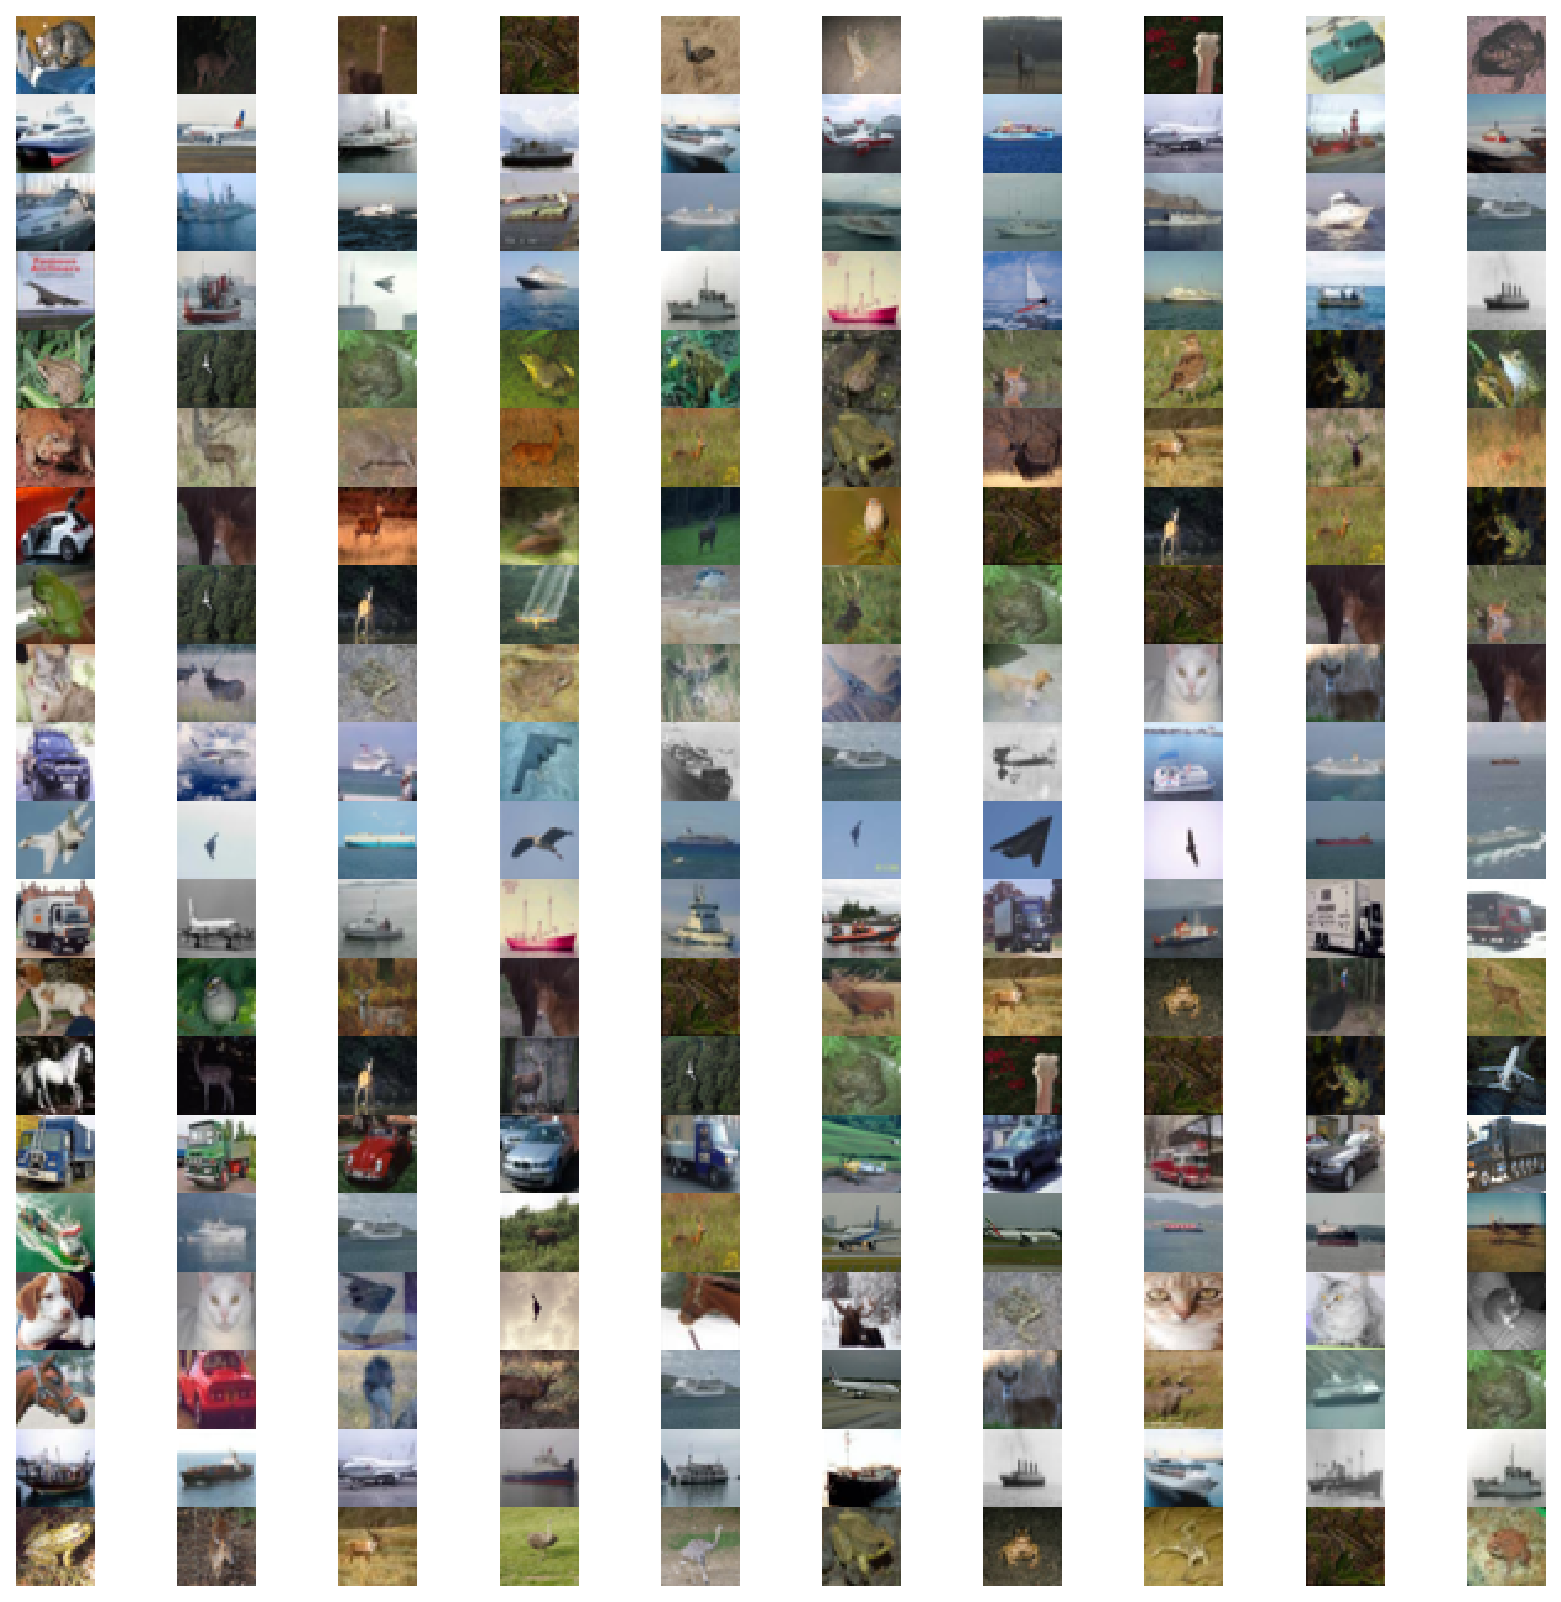

In [129]:
rn = 0
nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto', leaf_size=100, metric='l2').fit(feature_mat_test)
distances, indices = nbrs.kneighbors(feature_mat_test[rn:rn+20])
fig, axes1 = plt.subplots(20,10,figsize=(13,13), gridspec_kw = {'wspace':0, 'hspace':0}, dpi=80)
for j in range(20):
    for k in range(10):
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(cifar10_dataset_test[indices[j,k]][0])
plt.show()

In [ ]:
nbrs_pix = NearestNeighbors(n_neighbors=10, algorithm='auto', leaf_size=100, metric='euclidean').fit(feature_mat_pixel)
distances, indices = nbrs_pix.kneighbors(feature_mat_pixel[rn:rn+20])
fig, axes1 = plt.subplots(20,10,figsize=(13,13), gridspec_kw = {'wspace':0, 'hspace':0}, dpi=80)
for j in range(20):
    for k in range(10):
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(cifar10_dataset_test[indices[j,k]][0])
plt.show()

In [ ]:
index = faiss.IndexFlatL2(192*8*8)
index.add(feature_mat_test)
D, I = index.search(feature_mat_test, 10)
fig, axes1 = plt.subplots(20,10,figsize=(13,13), gridspec_kw = {'wspace':0, 'hspace':0}, dpi=80)
for j in range(20):
    for k in range(10):
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(cifar10_dataset_test[I[j,k]][0])
plt.show()

In [146]:
# def buildGraph_new(MatX, kernel_type, rbf_sigma=None, knn_num_neighbors=None, gamma=3):
#     num_samples = MatX.shape[0]
#     affinity_matrix = np.zeros((num_samples, num_samples), np.float32)
#     if kernel_type == 'rbf':
#         if rbf_sigma == None:
#             raise ValueError('You should input a sigma of rbf kernel!')
#         for i in range(num_samples):
#             row_sum = 0.0
#             for j in range(num_samples):
#                 diff = MatX[i, :] - MatX[j, :]
#                 affinity_matrix[i][j] = np.exp(sum(diff ** 2) / (-2.0 * rbf_sigma ** 2))
#                 row_sum += affinity_matrix[i][j]
#             affinity_matrix[i][:] /= row_sum
#     elif kernel_type == 'knn':
#         if knn_num_neighbors == None:
#             raise ValueError('You should input a k of knn kernel!')
#         nbrs = NearestNeighbors(n_neighbors=knn_num_neighbors, algorithm='auto', leaf_size=100, metric='euclidean').fit(MatX)
#         # distances, indices = nbrs.kneighbors(MatX)
#         # trns = lambda x: 0 if x < 0 else x
#         trns = lambda x: np.exp(x ** 2 /  (-2.0 * rbf_sigma ** 2))
#         trns = np.vectorize(trns)
#         for i in range(num_samples):
#             distances, indices = nbrs.kneighbors(MatX[[i]])
#             k_neighbors = indices[0]
#             k_nb_distances = distances[0]
#             # k_nb_affinity = 1 - k_nb_distances
#             k_nb_affinity = trns(k_nb_distances)
#             affinity_matrix[i][k_neighbors] = k_nb_affinity
#             affinity_matrix[i,i] = 0.0
#             if i%100 ==0:
#                 print(i)
#     else:
#         raise NameError('Not support kernel type! You can use knn or rbf!')

#     return (affinity_matrix + affinity_matrix.T)/2


def buildGraph_new(MatX, kernel_type, rbf_sigma=None, knn_num_neighbors=None, gamma=3):
    num_samples = MatX.shape[0]
    affinity_matrix = np.zeros((num_samples, num_samples), np.float32)
    if kernel_type == 'rbf':
        if rbf_sigma == None:
            raise ValueError('You should input a sigma of rbf kernel!')
        for i in range(num_samples):
            row_sum = 0.0
            for j in range(num_samples):
                diff = MatX[i, :] - MatX[j, :]
                affinity_matrix[i][j] = np.exp(sum(diff ** 2) / (-2.0 * rbf_sigma ** 2))
                row_sum += affinity_matrix[i][j]
            affinity_matrix[i][:] /= row_sum
    elif kernel_type == 'knn':
        if knn_num_neighbors == None:
            raise ValueError('You should input a k of knn kernel!')
        
#         index = faiss.IndexFlatL2(192*8*8)
        index = faiss.IndexFlatIP(192*8*8)
        

        index.add(MatX)
        distances, indices = index.search(MatX, knn_num_neighbors)
        
#         nbrs = NearestNeighbors(n_neighbors=knn_num_neighbors, algorithm='auto', leaf_size=100, metric='euclidean').fit(MatX)
        # distances, indices = nbrs.kneighbors(MatX)
        # trns = lambda x: 0 if x < 0 else x
#         trns = lambda x: np.exp(x ** 2 /  (-2.0 * rbf_sigma ** 2))
#         trns = np.vectorize(trns)
        
        trns = lambda x: 0 if x < 0 else x**gamma
        trns = np.vectorize(trns)
        
        for i in range(num_samples):
#             distances, indices = nbrs.kneighbors(MatX[[i]])
            k_neighbors = indices[i]
            k_nb_distances = distances[i]
            # k_nb_affinity = 1 - k_nb_distances
            k_nb_affinity = trns(k_nb_distances)
            affinity_matrix[i][k_neighbors] = k_nb_affinity
            affinity_matrix[i,i] = 0.0
#             if i%100 ==0:
#                 print(i)
    else:
        raise NameError('Not support kernel type! You can use knn or rbf!')

    return (affinity_matrix + affinity_matrix.T)/2

def labelPropagation_new(affinity_matrix, Mat_Label, Mat_Unlabel, labels, alpha=.1):
    # initialize
    num_label_samples = Mat_Label.shape[0]
    num_unlabel_samples = Mat_Unlabel.shape[0]
    num_samples = num_label_samples + num_unlabel_samples
    labels_list = np.unique(labels)
    num_classes = len(labels_list)

    # MatX = np.vstack((Mat_Label, Mat_Unlabel))
    clamp_data_label = np.zeros((num_label_samples, num_classes), np.float32)
    for i in range(num_label_samples):
        clamp_data_label[i][labels[i]] = 1.0

    label_function = np.zeros((num_samples, num_classes), np.float32)
    label_function[0: num_label_samples] = clamp_data_label
    label_function[num_label_samples: num_samples] = 0

    # graph construction
    # affinity_matrix = buildGraph_new(MatX, kernel_type, rbf_sigma, knn_num_neighbors)

    degree_vec = np.sum(affinity_matrix, axis=1)
    degree_vec_to_the_power_minus_half = 1/np.sqrt(degree_vec)
    degree_matrix_2_the_power_minus_half = np.diag(degree_vec_to_the_power_minus_half)
    d_minus_half_w_d_minus_half = multi_dot([degree_matrix_2_the_power_minus_half, affinity_matrix, degree_matrix_2_the_power_minus_half])

    dense_matrix = np.eye(num_samples) - alpha * d_minus_half_w_d_minus_half
    solution_list = []
    for i in range(num_classes):
        print(i)
        converged_solution = cg(dense_matrix, label_function[:,i])[0]
        converged_solution = np.reshape(converged_solution, (-1,1))
        solution_list.append(converged_solution)
    label_function = np.hstack(solution_list)

    unlabel_data_labels = np.zeros(num_unlabel_samples)
    for i in range(num_unlabel_samples):
        unlabel_data_labels[i] = np.argmax(label_function[i + num_label_samples])

    return unlabel_data_labels

In [147]:
cifar10_dataset = CIFAR10("/data02/Atin/data/cifar10/", train=True, transform=None, target_transform=None, download=True)
cifar10_dataset_test = CIFAR10("/data02/Atin/data/cifar10/", train=False, transform=None, target_transform=None, download=True)


dl_lp_train = DataloaderRotnet(cifar10_dataset, batch_size=128, unsupervised=False, shuffle=False)
dl_lp_test = DataloaderRotnet(cifar10_dataset_test, batch_size=128, unsupervised=False, shuffle=False)

feature_mat_train, label_train = sem_sup_feature(dl_lp_train)
feature_mat_test, label_test = sem_sup_feature(dl_lp_test)
whole_mat = torch.cat((feature_mat_train, feature_mat_test))
whole_label = torch.cat((label_train, label_test))

feature_mat_train, feature_mat_test, whole_mat = feature_mat_train.cpu().numpy(), feature_mat_test.cpu().numpy(), whole_mat.cpu().numpy()

Files already downloaded and verified
Files already downloaded and verified


In [148]:
train_label_index_lp = return_train_labels_index(Labels)
unlabel_index_lp = list(set(range(60000)) - set(train_label_index_lp))

Mat_Label = feature_mat_train[train_label_index_lp] #Labelled data matrix
labels = label_train[train_label_index_lp] #Corresponding labels of Labelled data matrix
Mat_Unlabel = whole_mat[unlabel_index_lp] #UnLabelled data matrix
rest_label = whole_label[unlabel_index_lp]

In [149]:
#Since knn graph building is very slow we try on small dataset 
Mat_Unlabel1 = Mat_Unlabel[:6000] #UnLabelled data matrix
rest_label1 = rest_label[:6000]

MatX = np.vstack((Mat_Label, Mat_Unlabel1))
MatX = MatX / np.linalg.norm(MatX, axis=-1)[:, np.newaxis]
affinity_matrix = buildGraph_new(MatX, "knn", None, 20, 1)

In [150]:
unlabel_data_labels = labelPropagation_new(affinity_matrix, Mat_Label, Mat_Unlabel1, labels, alpha=.4)

0
1
2
3
4
5
6
7
8
9


In [151]:
corrects = 0
for i in range(len(unlabel_data_labels)):
    if unlabel_data_labels[i] == rest_label1[i]:
        corrects +=1
corrects/len(unlabel_data_labels)

0.6738333333333333

In [87]:
index = faiss.IndexFlatL2(192*8*8)
index.add(MatX)
distances, indices = index.search(MatX, 10)

In [ ]:
I[0]

In [ ]:
indices[20]

In [ ]:
rbf_sigma = 1.5
num_samples = MatX.shape[0]
affinity_matrix = np.zeros((num_samples, num_samples), np.float32)
trns = lambda x: np.exp(x ** 2 /  (-2.0 * rbf_sigma ** 2))
trns = np.vectorize(trns)
for i in range(num_samples):
    k_neighbors = indices[i]
    k_nb_distances = distances[i]
    k_nb_affinity = trns(k_nb_distances)
    affinity_matrix[i][k_neighbors] = k_nb_affinity
    affinity_matrix[i,i] = 0.0
affinity_matrix = (affinity_matrix + affinity_matrix.T)/2

In [ ]:
2+3